# Предподготовка данных

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from scipy.stats import randint, uniform

import gc

In [2]:
train_data = pd.read_csv('shift_ml_2026_train.csv')
train_data.head()

/tmp/ipykernel_174384/3051227295.py:1: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('shift_ml_2026_train.csv')


,id,сумма_займа,срок_займа,процентная_ставка,аннуитет,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,...,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам,особая_ситуация,тип_предоставления_кредита
0,68355089,1235000.0,3 года,11.99,41014.0,В,В1,инженер,10+ лет,ИПОТЕКА,...,7.7,0.0,0.0,15700850.0,1973750.0,3965000.0,1233350.0,NaN,Нет,Наличные
1,68341763,1000000.0,5 лет,10.78,21633.0,Б,Б4,водитель грузовика,10+ лет,ИПОТЕКА,...,50.0,0.0,0.0,10920900.0,934800.0,310000.0,743850.0,NaN,Нет,Наличные
2,68426831,597500.0,3 года,13.44,20259.0,В,В3,ветеринарный техник,4 года,АРЕНДА,...,100.0,0.0,0.0,845000.0,639900.0,470000.0,200000.0,NaN,Нет,Наличные
3,68476668,1000000.0,3 года,9.17,31879.0,Б,Б2,вице-президент операций по набору персонала,10+ лет,ИПОТЕКА,...,100.0,0.0,0.0,19442600.0,5838100.0,1575000.0,2322600.0,NaN,Нет,Наличные
4,67275481,1000000.0,3 года,8.49,31563.0,Б,Б1,дорожному водителю,10+ лет,ИПОТЕКА,...,0.0,0.0,0.0,9669500.0,1396850.0,725000.0,1807200.0,NaN,Нет,Наличные


In [3]:
# Определяем процентное содержание пропусков (NaN) в столбцах
missing = train_data.isna().sum()
missing = missing.loc[missing > 0]
missing_percent = (missing / len(train_data) * 100).round(2).sort_values(ascending=False)

# Отсекаем столбцы с пропусками >= 50% (24 шт.), т.к. они будут неинформативны при обучении модели
cols_drop = missing_percent.loc[missing_percent >= 50].index
train_data = train_data.drop(cols_drop, axis=1)
print(f'Оставшееся количество колонок: {len(train_data.columns)}')

Оставшееся количество колонок: 85


In [4]:
# Оставшиеся колонки с пропусками
missing_2 = train_data.isna().sum()
count_missing = len(missing_2.loc[missing_2 > 0])
print(f'Количество колонок с пропусками: {count_missing}')

Количество колонок с пропусками: 45


## Удаляем неинформативные столбцы
- "платежный_график" - все значения "n"
- "коэфф_невыплаченного_сумм_остатка" - все значения "1.345312e+06"
- "непогашенная_сумма_из_тела_займов" - все значения "0.0"
- "код_политики" - все значения "1.0"
- "особая_ситуация" - все значения "Нет"
- "кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес" - 99.3% составляют значения 0.0 и NaN
- "кол-во_счетов_с_акт_просрочкой_1_мес"  - 99.7% составляют значения 0.0 и NaN

In [5]:
drop_columns = ['платежный_график', 'коэфф_невыплаченного_сумм_остатка', 'непогашенная_сумма_из_тела_займов',
                 'код_политики', 'особая_ситуация', 'кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес',
                 'кол-во_счетов_с_акт_просрочкой_1_мес']

train_data = train_data.drop(drop_columns, axis=1)

## Train, test

In [6]:
# Перед заполнением пропусков в колонках разбиваем на тренировочную и валидационную выборки, чтобы не допусть утечки данных
X = train_data.drop('итоговый_статус_займа', axis=1)
y = train_data['итоговый_статус_займа']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2 , random_state=42, stratify=y) 

del X, y, train_data

## Обработка пропусков
"пени_за_дефолт" - 30% пропусков.  

In [7]:
# Определим связь 'пени_за_дефолт' с таргетом - 'итоговый_статус_займа'
temp_train_data = pd.concat([X_train, y_train], axis=1)

count_default = temp_train_data.groupby(['пени_за_дефолт', 'итоговый_статус_займа'], as_index=False, dropna=False).\
                                aggregate({'id': 'count'}).rename({'id': 'count'}, axis=1)

sum_group = count_default.groupby('пени_за_дефолт', dropna=False, as_index=False).\
                aggregate({'count': 'sum'}).rename({'count': 'sum_group'}, axis=1)

count_default = pd.merge(count_default, sum_group, on='пени_за_дефолт')
count_default['percent'] = (count_default['count'] / count_default['sum_group'] * 100).round(2)

count_default

,пени_за_дефолт,итоговый_статус_займа,count,sum_group,percent
0,NaN,0,232895,290605,80.14
1,NaN,1,57710,290605,19.86
2,False,0,542373,588699,92.13
3,False,1,46326,588699,7.87
4,True,1,89319,89319,100.00


При определении процента дефолтных случаев в каждой из 3х групп (True, False, NaN) колонки пени_за_дефолт выявлено:  
- в группе True 100% дефолтов (наибольший риск)  
- в группе NaN примернро 20% дефолтов (средний риск)  
- в группе False примерно 8% дефолтов (наименьший риск)  
  
Преобразуем значения в соответствии с их рисками: True - 2, NaN - 1, False - 0

In [8]:
# Заменяем значения в столбце "пени_за_дефолт"
map_peni = {False: 0, float('nan'): 1, True: 2}

X_train['пени_за_дефолт_ЗАКОДИР'] = X_train['пени_за_дефолт'].map(map_peni)
X_valid['пени_за_дефолт_ЗАКОДИР'] = X_valid['пени_за_дефолт'].map(map_peni)

X_train = X_train.drop('пени_за_дефолт', axis=1)
X_valid = X_valid.drop('пени_за_дефолт', axis=1)

"кол-во_мес_с_последней_заявки" (12% пропусков)

Text(0, 0.5, 'Частота')

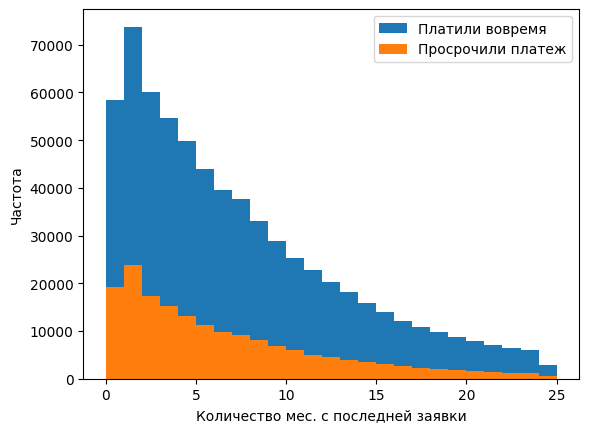

In [9]:
# Построим гистограмму распределения частоты данных для двух групп: платили вовремя, просрочили платеж
months_without_app_OK  = temp_train_data.loc[temp_train_data['итоговый_статус_займа'] == 0]['кол-во_мес_с_последней_заявки']
months_without_app_default = temp_train_data.loc[temp_train_data['итоговый_статус_займа'] == 1]['кол-во_мес_с_последней_заявки']

plt.hist(months_without_app_OK, bins=25, label='Платили вовремя')
plt.hist(months_without_app_default, bins=25, label='Просрочили платеж')

plt.legend(loc='upper right')

plt.xlabel('Количество мес. с последней заявки')
plt.ylabel('Частота')

Распределение двух групп (0 и 1 по таргету) схоже между собой и имеет равномерную нисходящую форму  
Заменять на медианное или среднее значение нельзя, т.к. это создать пик, которого раньше не было  
Создадим новое значение для NaN (-1), по которому деревовидные модели смогут делать сплит, а для линейных моделей  
добавим новую колонку-индикатор

In [10]:
X_train['кол-во_мес_с_последней_заявки_ИНДИКАТОР'] = X_train['кол-во_мес_с_последней_заявки'].isna().astype(int)
X_valid['кол-во_мес_с_последней_заявки_ИНДИКАТОР'] = X_valid['кол-во_мес_с_последней_заявки'].isna().astype(int)

X_train['кол-во_мес_с_последней_заявки'] = X_train['кол-во_мес_с_последней_заявки'].fillna(-1.0)
X_valid['кол-во_мес_с_последней_заявки'] = X_valid['кол-во_мес_с_последней_заявки'].fillna(-1.0)

"кол-во_месяцев_с_первого_аннуитетного_счета" (8% пропусков)

(0.0, 300.0)

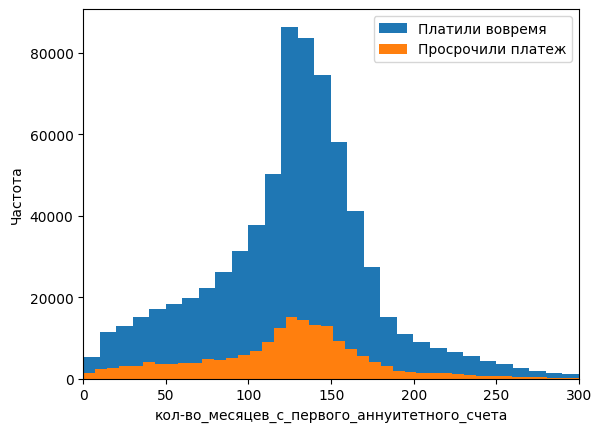

In [11]:
# Построим гистограмму распределения частоты данных для двух групп: платили вовремя, просрочили платеж
months_first_Invoice_OK  = temp_train_data.loc[temp_train_data['итоговый_статус_займа'] == 0]['кол-во_месяцев_с_первого_аннуитетного_счета']
months_first_Invoice_default = temp_train_data.loc[temp_train_data['итоговый_статус_займа'] == 1]['кол-во_месяцев_с_первого_аннуитетного_счета']

plt.hist(months_first_Invoice_OK, bins=100, label='Платили вовремя')
plt.hist(months_first_Invoice_default, bins=100, label='Просрочили платеж')

plt.legend(loc='upper right')

plt.xlabel('кол-во_месяцев_с_первого_аннуитетного_счета')
plt.ylabel('Частота')

plt.xlim(0, 300)

In [12]:
del  temp_train_data, months_first_Invoice_OK, months_first_Invoice_default, months_without_app_OK, months_without_app_default

Определим отношение количества дефолтных случаев в строках с NaN и строках без пропусков, чтобы понять:  
доля дефолтов больше, меньше или разница незначительна

In [13]:
# Определим отношение количества дефолтов в двух группах (для NaN и без NaN)
def risk_calculation(data, target):
    col_with_NaN = data.columns[data.isna().any()].tolist()
    data_NaN = data[col_with_NaN].copy()

    # Проверка длины датафрейма и таргета
    if len(data) == len(target):
        data_NaN['target'] = target.values
    else:
        raise ValueError("Длины data и target не совпадают: "
                  f"len(data)={len(data)}, len(target)={len(target)}") 

    results = []

    # Расчет доли дефолтных случаев для каждого столбца для 2х групп (с NaN и без них)
    for col in data_NaN.columns[:-1]:
        missing_perc = data_NaN[col].isna().mean() * 100

        percent_default_NaN  = data_NaN.loc[data_NaN[col].isna()]['target'].mean()
        percent_default_noNaN = data_NaN.loc[data_NaN[col].notna()]['target'].mean()

        if percent_default_noNaN != 0:
            share_of_risk_default = percent_default_NaN / percent_default_noNaN
        else:
            share_of_risk_default = float('nan')

        results.append({
            'name_column': col,
            'missing_perc': round(missing_perc, 3),
            'percent_default_NaN': round(percent_default_NaN, 2),
            'percent_default_noNaN': round(percent_default_noNaN, 2),
            'share_of_risk_default': round(share_of_risk_default, 2)
        })

    info_result = pd.DataFrame(results)

    gc.collect()

    return info_result.sort_values('share_of_risk_default', ascending=False)

In [14]:
# Результат
risk_calculation_data = risk_calculation(X_train, y_train)
risk_calculation_data

,name_column,missing_perc,percent_default_NaN,percent_default_noNaN,share_of_risk_default
1,стаж,5.831,0.27,0.2,1.37
0,профессия_заемщика,6.374,0.26,0.2,1.34
5,коэфф_загрузки_возобновляемого_счета,0.063,0.19,0.2,0.96
3,пдн,0.028,0.18,0.2,0.92
15,кол-во_месяцев_с_первого_аннуитетного_счета,7.855,0.17,0.2,0.87
35,кол-во_публ_банкротств,0.051,0.16,0.2,0.82
13,соотношение_баланса_к_лимиту_по_картам,4.603,0.16,0.2,0.79
12,суммарная_доступная_сумма_займа_по_картам,4.545,0.16,0.2,0.79
34,процент_счетов_прев_75_лимита,4.576,0.16,0.2,0.79
20,кол-во_месяцев_с_последней_карты,4.474,0.16,0.2,0.79


Из "missing_perc" видно, что для 18 колонок доля NaN одинакова (5.016). Проверим, совпадают ли пропуски у этих колонок

In [15]:
# Проверим, совпадают ли NaN у столбцов со значением missing_perc = 5.016 (процент NaN)
list_col_one = risk_calculation_data[risk_calculation_data['missing_perc'] == 5.016]['name_column'].tolist()
data_NaN_temp = X_train[list_col_one].loc[X_train[list_col_one]['лимит_по_аннуитетным_счетам'].isna()]
data_NaN_temp.isna().sum()

лимит_по_аннуитетным_счетам                          48585
общая_сумма_на_счетах                                48585
общая_сумма_взысканий                                48585
кол-во_счетов_за_посл_год                            48585
кол-во_месяцев_с_первого_возобновляемого_счета       48585
кол-во_активных_возобновляемых_счетов                48585
кол-во_активных_карт                                 48585
кол-во_месяцев_с_последнего_счета                    48585
кол-во_счетов_с_просрочкой_4_мес                     48585
кол-во_аннуитетных_счетов                            48585
кол-во_карт                                          48585
кол-во_месяцев_с_последнего_возобновляемого_счета    48585
общий_лимит_по_возоб_счету                           48585
кол-во_возобновляемых_счетов_с_балансом_более_0      48585
кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года       48585
кол-во_открытых_возобновляемых_счетов                48585
кредитный_лимит                                      485

1) Количество совпадает, значит для всех этих колонок можно создать одну общую колонку-индикатор, а пропуски заменить на (-1)
2) Аналогично для колонок: 'кол-во_открытых_счетов_за_2_года', 'лимит_по_картам', 'кредитный_баланс_без_ипотеки', 'кол-во_ипотек'
3) Аналогично для колонок: 'кол-во_счетов_без_нарушений', 'кол-во_карт_без_нарушений'
4) Для колонок с missing_perc < 1% замена NaN на медианное значение
5) Для всех остальных - замена на (-1) + колонка-индикатор

In [16]:
# Проверка колонок с 'missing_perc' == 4.145
list_col_one_2 = risk_calculation_data[risk_calculation_data['missing_perc'] == 4.145]['name_column'].tolist()
data_NaN_temp_2 = X_train[list_col_one_2].loc[X_train[list_col_one_2]['кол-во_счетов_без_нарушений'].isna()]
data_NaN_temp_2.isna().sum()

кол-во_счетов_без_нарушений    40145
кол-во_карт_без_нарушений      40145
dtype: int64

In [17]:
# Проверка колонок с 'missing_perc' == 3.507
list_col_one_3 = risk_calculation_data[risk_calculation_data['missing_perc'] == 3.507]['name_column'].tolist()
data_NaN_temp_3 = X_train[list_col_one_3].loc[X_train[list_col_one_3]['лимит_по_картам'].isna()]
data_NaN_temp_3.isna().sum()

кол-во_открытых_счетов_за_2_года    33972
лимит_по_картам                     33972
кредитный_баланс_без_ипотеки        33972
кол-во_ипотек                       33972
dtype: int64

In [18]:
# Колонки 'missing_perc' < 1
list_col_median = risk_calculation_data[risk_calculation_data['missing_perc'] < 1]['name_column'].tolist()

# Остальные колонки
drop_col_risk = list_col_one + list_col_one_2 + list_col_one_3 + list_col_median
list_col_others = risk_calculation_data.loc[(~risk_calculation_data['name_column'].isin(drop_col_risk))]['name_column'].tolist()

In [19]:
# Заменяем NaN в сгруппированных столбцах
X_train['ИНДИКАТОР_1'] = X_train[list_col_one[0]].isna().astype(int)
X_valid['ИНДИКАТОР_1'] = X_valid[list_col_one[0]].isna().astype(int)
X_train[list_col_one] = X_train[list_col_one].fillna(-1)
X_valid[list_col_one] = X_valid[list_col_one].fillna(-1)

X_train['ИНДИКАТОР_2'] = X_train[list_col_one_2[0]].isna().astype(int)
X_valid['ИНДИКАТОР_2'] = X_valid[list_col_one_2[0]].isna().astype(int)
X_train[list_col_one_2] = X_train[list_col_one_2].fillna(-1)
X_valid[list_col_one_2] = X_valid[list_col_one_2].fillna(-1)

X_train['ИНДИКАТОР_3'] = X_train[list_col_one_3[0]].isna().astype(int)
X_valid['ИНДИКАТОР_3'] = X_valid[list_col_one_3[0]].isna().astype(int)
X_train[list_col_one_3] = X_train[list_col_one_3].fillna(-1)
X_valid[list_col_one_3] = X_valid[list_col_one_3].fillna(-1)


In [20]:
# Заменяем NaN в колонках 'missing_perc' < 1 на медианно значение
median_value = X_train[list_col_median].median()
X_train[list_col_median] = X_train[list_col_median].fillna(median_value)
X_valid[list_col_median] = X_valid[list_col_median].fillna(median_value)

In [21]:
# Заменяем NaN в остальных колонках, кроме "профессия_заемщика" (в ней на "нет_данных")
for col in list_col_others:
    X_train[f'{col}_ИНДИКАТОР'] = X_train[col].isna().astype(int)
    X_valid[f'{col}_ИНДИКАТОР'] = X_valid[col].isna().astype(int)

new_list_col_others = [x for x in list_col_others if x != 'профессия_заемщика']
X_train[new_list_col_others] = X_train[new_list_col_others].fillna(-1)
X_valid[new_list_col_others] = X_valid[new_list_col_others].fillna(-1)

X_train['профессия_заемщика'] = X_train['профессия_заемщика'].fillna('нет_данных')
X_valid['профессия_заемщика'] = X_valid['профессия_заемщика'].fillna('нет_данных')

## Замена категориальных признаков на числовые

"профессия_заемщика" - приерно 230 тыс уникальных профессий  
Заменим их на частотные характеристики столбца, чтобы модели находили взаимосвязь таргета с ними:  
- Частота профессии
- Бинарный признак - редкая ли профессия (меньше 0.1%)
- Бинарный признак - входит ли в топ 20 профессий по количеству

In [22]:
# Новый столбец - чaстотность профессий
value_counts_prof = X_train['профессия_заемщика'].value_counts()
X_train['частотность_профессии_заемщика'] = X_train['профессия_заемщика'].map(value_counts_prof)
X_valid['частотность_профессии_заемщика'] = X_valid['профессия_заемщика'].map(value_counts_prof).fillna(value_counts_prof.loc['нет_данных'])

# Новый столбец - редкость профессии
X_train['редкая_профессия_заемщика'] = ((X_train['частотность_профессии_заемщика'] / len(X_train)) < 0.001).astype(int)
X_valid['редкая_профессия_заемщика'] = ((X_valid['частотность_профессии_заемщика'] / len(X_train)) < 0.001).astype(int)

# Новый столбец - топ 20 профессий (кроме строк где нет данных)
top_20_prof = value_counts_prof[value_counts_prof.index != 'нет_данных'][:20].index.to_list()
X_train['ТОП20_профессий_заемщика'] = X_train['профессия_заемщика'].isin(top_20_prof).astype(int)
X_valid['ТОП20_профессий_заемщика'] = X_valid['профессия_заемщика'].isin(top_20_prof).astype(int)

X_train = X_train.drop('профессия_заемщика', axis=1)
X_valid = X_valid.drop('профессия_заемщика', axis=1)

"рейтинг" и "допрейтинг"  
"допрейтинг" (В1) повторяет "рейтинг" (В) с добавлением цифры.  
Заменим "допрейтинг" на числовые значения, "рейтинг" - удалим.

In [23]:
# Заменяем значеня в "допрейтинг" на упорядлоченный числовой рейтинг
list_ratings = X_train['допрейтинг'].value_counts().sort_index().index.to_list()
dict_value = {value: index for index, value in enumerate(list_ratings)}
X_train['допрейтинг'] = X_train['допрейтинг'].map(dict_value)
X_valid['допрейтинг'] = X_valid['допрейтинг'].map(dict_value).fillna(-1)

X_train = X_train.drop('рейтинг', axis=1)
X_valid = X_valid.drop('рейтинг', axis=1)

"стаж" - заменяем на числа (кол-во лет опыта)

In [24]:
# Заменяем значения в колонке "стаж"
X_train['стаж'] = X_train['стаж'].apply(lambda x: -1 if type(x)==int else 0 if x.split()[0]=='<' else
                                            10 if x.split()[0]=='10+' else int(x.split()[0]))
X_valid['стаж'] = X_valid['стаж'].apply(lambda x: -1 if type(x)==int else 0 if x.split()[0]=='<' else
                                            10 if x.split()[0]=='10+' else int(x.split()[0]))

"владение_жильем" - объединяем категории, кол-во которых невелико (<= 200 строк): "ЛЮБОЕ", "ДРУГОЕ", "НЕТ" -> "ДРУГОЕ"  
Затем раскладываем по "One Hot Encoding"

In [25]:
# Объединяем малочисленные значения
list_ownership = ['ЛЮБОЕ', 'ДРУГОЕ', 'НЕТ']
X_train['владение_жильем'] = X_train['владение_жильем'].apply(lambda x: 'ДРУГОЕ' if x in list_ownership else x)
X_valid['владение_жильем'] = X_valid['владение_жильем'].apply(lambda x: 'ДРУГОЕ' if x in list_ownership else x)

'цель_займа' - категориальный признак (14 категорий)  
Те категории, число которых менее 10 000 шт (менее 1% от всех данных) сгруппируются с другими категориями на основании доли количества невозвратов

In [26]:
# Определяем долю невозвратов
grouping_data = pd.concat([X_train, y_train], axis=1).\
                    groupby(['цель_займа', 'итоговый_статус_займа'], as_index=False).aggregate({'id': 'count'})
grouping_data['ratio'] = grouping_data.groupby('цель_займа')['id'].transform(lambda x: x / x.sum()).round(2)

grouping_data.loc[grouping_data['итоговый_статус_займа'] == 1].sort_values('ratio', ascending=False)

,цель_займа,итоговый_статус_займа,id,ratio
17,мелкий_бизнес,1,3313,0.30
3,возобновляемая_энергия,1,157,0.24
23,переезд,1,1596,0.23
15,лечение,1,2448,0.22
9,консолидация_долга,1,118916,0.21
5,дом,1,1127,0.21
7,другое,1,11832,0.21
13,крупная_покупка,1,3941,0.19
21,отпуск,1,1267,0.19
27,улучшение_жилищных_условий,1,11083,0.18


['переезд', 'возобновляемая_энергия'] -> 'лечение'  
'отпуск' -> 'крупная_покупка'  
'дом' -> 'консолидация_долга'  
['свадьба', 'образование'] -> 'автомобиль'


In [27]:
# Заменяем малочисленные значения
X_train['цель_займа'] = X_train['цель_займа'].apply(lambda x: 'лечение' if x in ['переезд', 'возобновляемая_энергия'] else 
                                                    'крупная_покупка' if x == 'отпуск' else 
                                                    'консолидация_долга' if x == 'дом' else 'автомобиль' if x in ['свадьба', 'образование'] else x)

list_purpose = X_train['цель_займа'].unique().tolist()
X_valid['цель_займа'] = X_valid['цель_займа'].apply(lambda x: 'лечение' if x in ['переезд', 'возобновляемая_энергия'] else 
                                                    'крупная_покупка' if x == 'отпуск' else 
                                                    'консолидация_долга' if x == 'дом' else 'автомобиль' if x in ['свадьба', 'образование'] else x
                                                    if x in list_purpose else 'другое')

One Hot Encoding

In [28]:
# Чтобы новые колонки были одинаковыми в train и valid, временно объединим их
one_hot_list =['владение_жильем', 'подтвержден_ли_доход', 'цель_займа']
comb_train_valid = pd.concat([X_train[one_hot_list],
                              X_valid[one_hot_list]])

# One Hot Encoding
comb_dummies = pd.get_dummies(comb_train_valid, prefix=one_hot_list, dtype=int)

# Разделяем обратно
train_dummies = comb_dummies.iloc[:len(X_train)]
valid_dummies = comb_dummies.iloc[len(X_train):]

# Соединяем с изначальными датафреймами
X_train = pd.concat([X_train, train_dummies], axis=1)
X_valid = pd.concat([X_valid, valid_dummies], axis=1)

# Удаляем исходные столбцы
X_train = X_train.drop(one_hot_list, axis=1)
X_valid = X_valid.drop(one_hot_list, axis=1)

# Очищаем память
del comb_train_valid, train_dummies, valid_dummies, comb_dummies

## Остальная обработка
'тип_займа' - заменяем 'Индивидуальный' и 'Совместный' на 0 и 1  
'пос_стоп_фактор' - заменяем значения 'Нет', 'Под вопросом', 'Да' на 0, 0.5, 1  
'юридический_статус' - заменяем значения 'Нет', 'Да' на 0 и 1  
'дата_первого_займа' - убираем месяц, оставляем только год  
'первоначальный_статус_займа' - заменяем 'а' и 'б' на 0 и 1  
'тип_предоставления_кредита' - заменяем 'Наличные' и 'Перевод' на 0 и 1  
'срок_займа' - оставляем только цифры 3 и 5 вместо "3 года" и "5 лет"

In [29]:
# Замена значений в 'тип_займа'
replace_type = {'Индивидуальный': 0, 'Совместный': 1}
X_train['тип_займа'] = X_train['тип_займа'].map(replace_type)
X_valid['тип_займа'] = X_valid['тип_займа'].map(replace_type)

# Замена значений в 'пос_стоп_фактор'
replace_factor = {'Нет': 0, 'Под вопросом': 0.5, 'Да': 1}
X_train['пос_стоп_фактор'] = X_train['пос_стоп_фактор'].map(replace_factor)
X_valid['пос_стоп_фактор'] = X_valid['пос_стоп_фактор'].map(replace_factor)

# Замена значений в 'юридический_статус'
replace_status = {'Нет': 0, 'Да': 1}
X_train['юридический_статус'] = X_train['юридический_статус'].map(replace_status)
X_valid['юридический_статус'] = X_valid['юридический_статус'].map(replace_status)

# Замена значений в 'дата_первого_займа'
X_train['дата_первого_займа'] = X_train['дата_первого_займа'].apply(lambda x: int(x.split('-')[1]))
X_valid['дата_первого_займа'] = X_valid['дата_первого_займа'].apply(lambda x: int(x.split('-')[1]))

# Замена значений в 'первоначальный_статус_займа'
replace_loan_status = {'а': 0, 'б': 1}
X_train['первоначальный_статус_займа'] = X_train['первоначальный_статус_займа'].map(replace_loan_status)
X_valid['первоначальный_статус_займа'] = X_valid['первоначальный_статус_займа'].map(replace_loan_status)

# Замена значений в 'тип_предоставления_кредита'
replace_type_cash = {'Наличные': 0, 'Перевод': 1}
X_train['тип_предоставления_кредита'] = X_train['тип_предоставления_кредита'].map(replace_type_cash)
X_valid['тип_предоставления_кредита'] = X_valid['тип_предоставления_кредита'].map(replace_type_cash)

# Замена значений в 'срок_займа'
replace_loan_term = {'3 года': 3, '5 лет': 5}
X_train['срок_займа'] = X_train['срок_займа'].map(replace_loan_term)
X_valid['срок_займа'] = X_valid['срок_займа'].map(replace_loan_term)

'регион' - Target Encoding  
Заменим 51 регион на долю дефолтов в этих регионов.

In [30]:
# Расчитываем долю дефолтов для каждого региона
temp_data_region = pd.concat([X_train['регион'], y_train], axis=1)
temp_data_region['доля_дефолтов'] = temp_data_region.\
                                        groupby('регион', as_index=False)['итоговый_статус_займа'].\
                                        transform(lambda x: x.mean())

temp_data_region_unique = temp_data_region[['регион', 'доля_дефолтов']].\
                                        groupby('регион').\
                                        aggregate({'доля_дефолтов': 'first'})

# Создаем колонку со значениями доли дефолтов в регионах
X_train['доля_дефолтов_по_регионам'] = X_train['регион'].map(temp_data_region_unique['доля_дефолтов'])
X_valid['доля_дефолтов_по_регионам'] = X_valid['регион'].map(temp_data_region_unique['доля_дефолтов']).fillna(0)

# Удаляем колонку "регион"
X_train = X_train.drop('регион', axis=1)
X_valid = X_valid.drop('регион', axis=1)

# Очищаем память
del temp_data_region

## Проверка на мультиколлинеарность

In [31]:
corr_matrix = X_train.corr()

In [32]:
# Найдем сильно коррелирующие между собой колонки (пороговое значение 0.9)
treshold = 0.9
corr_matrix_tresh = corr_matrix[(corr_matrix >= treshold) | (corr_matrix <= -treshold)]

dict_corr = {}
for col in corr_matrix_tresh.columns:
    dict_corr[col] = corr_matrix_tresh[col].loc[~(corr_matrix_tresh[col].isna())].loc[col:].drop(col).index.to_list()

dict_corr_clean_null = {k: v for k, v in dict_corr.items() if v}

<pre>
Оставим только одну из коррелирующих фичей:  

    Оставляем                                Удаляем
1) 'сумма_займа'                            'аннуитет'  
2) 'допрейтинг',                            'процентная_ставка' ('допрейтинг' описывает клиента)
3) 'нижний_порог_рейтинга_заемщика',        'верхний_порог_рейтинга_заемщика' (по первому лучше определять риск невозврата)
4) 'кол-во_открытых_счетов'                 'кол-во_счетов_без_нарушений'
5) 'общая_сумма_на_счетах'                  'кредитный_лимит'
6) 'кол-во_активных_возобновляемых_счетов'  'кол-во_возобновляемых_счетов_с_балансом_более_0'
7) 'процент_счетов_без_просрочек'           'ИНДИКАТОР_1', 'процент_счетов_без_просрочек_ИНДИКАТОР',
                                            'средний_баланс_текущих_счетов_ИНДИКАТОР'
8) 'ИНДИКАТОР_2'                            'ИНДИКАТОР_3'
9) 'стаж_ИНДИКАТОР'                         'профессия_заемщика_ИНДИКАТОР', 'частотность_профессии_заемщика'
10)'соотношение_баланса_к_лимиту
    _по_картам_ИНДИКАТОР'                   'суммарная_доступная_сумма_займа_по_картам_ИНДИКАТОР',
                                            'процент_счетов_прев_75_лимита_ИНДИКАТОР',  
                                            'кол-во_месяцев_с_последней_карты_ИНДИКАТОР'

</pre>

In [33]:
# Удаляем коррелирующие фичи
list_corr_drop = ['аннуитет', 'процентная_ставка', 'верхний_порог_рейтинга_заемщика', 'кол-во_счетов_без_нарушений',
                  'кредитный_лимит', 'кол-во_возобновляемых_счетов_с_балансом_более_0', 'ИНДИКАТОР_1',
                  'процент_счетов_без_просрочек_ИНДИКАТОР', 'средний_баланс_текущих_счетов_ИНДИКАТОР',
                  'ИНДИКАТОР_3', 'профессия_заемщика_ИНДИКАТОР', 'частотность_профессии_заемщика',
                  'суммарная_доступная_сумма_займа_по_картам_ИНДИКАТОР', 'процент_счетов_прев_75_лимита_ИНДИКАТОР',
                  'кол-во_месяцев_с_последней_карты_ИНДИКАТОР']

X_train = X_train.drop(list_corr_drop, axis=1)
X_valid = X_valid.drop(list_corr_drop, axis=1)

In [34]:
# Удалим неинформативный столбец "id"
X_train = X_train.drop('id', axis=1)
X_valid = X_valid.drop('id', axis=1)

## Выбросы

Text(0, 0.5, 'Значение')

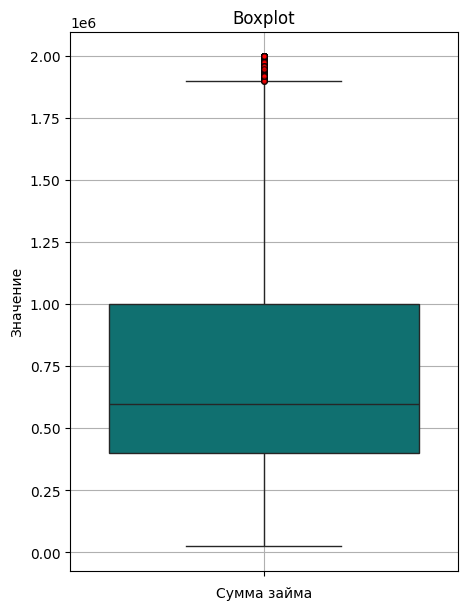

In [35]:
# График, для определения наличия выбросов
fig, ax = plt.subplots(figsize=(5, 7))

sns.boxplot(X_train['сумма_займа'],
            color='teal',
            ax=ax,
            flierprops={
            'marker': 'o',
            'markerfacecolor': 'red',
            'markeredgecolor': 'black',
            'markersize': 4,
            'alpha': 0.7
            })

ax.grid(True)
ax.set_title('Boxplot')
ax.set_xlabel('Сумма займа')
ax.set_ylabel('Значение')

В "сумма_займа" выбросы находятся в верхней части значений  
Определим конкретные значения

In [36]:
# Выбросы в колонке"сумма_займа"
Q1 = X_train['сумма_займа'].quantile(0.25)
Q3 = X_train['сумма_займа'].quantile(0.75)
IQR = Q3 - Q1

upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR

X_train['сумма_займа'].loc[(X_train['сумма_займа'] < lower_limit) | (X_train['сумма_займа'] > upper_limit)].value_counts()

сумма_займа
2000000.0    4851
1920000.0      53
1950000.0      41
1960000.0      25
1980000.0      16
             ... 
1966250.0       1
1922500.0       1
1976250.0       1
1983750.0       1
1961250.0       1
Name: count, Length: 69, dtype: int64

Значения, которые находятся выше верхней границы находятся в диапазоне от 1,9 млн до 2 млн.  
Аномальных значений не обнаружено - оставляем как есть.  
Проанализируем по аналогии остальные колонки с непрерывными значениями:  
1) 'пдн'- есть выбросы сверху (больше 100% от дохода, что нелогично) -> Ограничим 99-ым перцентилем.
2) 'дата_первого_займа' - есть выбросы снизу (1934 год и т.п.) -> отсечем их 1-ым перцентилем (1975 год)
3) 'сумма_выплат_по_просрочкам' - есть выбросы сверху и снизу -> ограничим значения 1-ым и 99-ым перцентилем
4) есть выбросы сверху -> ограничим значения единицей (чтобы не обнулить все значения при ограничении 99-ым перцентилем)
'кол-во_текущих_просроченных_счетов', 'кол-во_списаний_за_год', 'сумма_задолженности'
5) Есть выбросы сверху -> ограничим значения 99-ым перцентилем:  
'кол-во_взысканий_за_последний_год', 'кол-во_счетов', 'коэфф_загрузки_возобновляемого_счета', 'оборотный_баланс', 'кол-во_записей_в_общедоступных_документах', 'кол-во_открытых_счетов', 'общая_сумма_взысканий', 'общая_сумма_на_счетах', 'общий_лимит_по_возоб_счету', 'кол-во_открытых_счетов_за_2_года', 'средний_баланс_текущих_счетов', 'суммарная_доступная_сумма_займа_по_картам',
'соотношение_баланса_к_лимиту_по_картам', 'кол-во_месяцев_с_первого_аннуитетного_счета', 'кол-во_месяцев_с_первого_возобновляемого_счета', 'кол-во_месяцев_с_последнего_возобновляемого_счета', 'кол-во_месяцев_с_последнего_счета', 'кол-во_ипотек', 'кол-во_месяцев_с_последней_карты', 'кол-во_счетов_с_просрочкой_4_мес', 'кол-во_активных_карт', 'кол-во_активных_возобновляемых_счетов', 'кол-во_карт_без_нарушений', 'кол-во_карт', 'кол-во_аннуитетных_счетов', 'кол-во_открытых_возобновляемых_счетов', 'кол-во_возобновляемых_счетов', 'кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года', 'кол-во_счетов_за_посл_год', 'кол-во_публ_банкротств', 'кол-во_залогов', 'кредитный_баланс_без_ипотеки', 'лимит_по_картам', 'лимит_по_аннуитетным_счетам'

Text(0, 0.5, 'Значение')

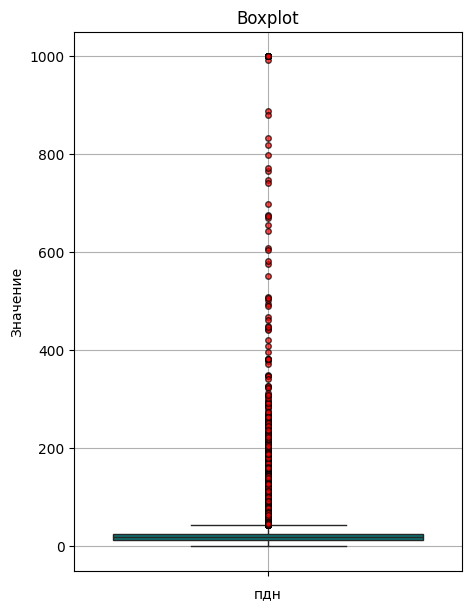

In [37]:
# Boxplor 'пдн' до исправления
fig, ax = plt.subplots(figsize=(5, 7))

sns.boxplot(X_train['пдн'],
            color='teal',
            ax=ax,
            flierprops={
            'marker': 'o',
            'markerfacecolor': 'red',
            'markeredgecolor': 'black',
            'markersize': 4,
            'alpha': 0.7
            })

ax.grid(True)
ax.set_title('Boxplot')
ax.set_xlabel('пдн')
ax.set_ylabel('Значение')

In [38]:
# Ограничиваем значения 99-ым перцентилем
list_99_perc_col = ['пдн', 'кол-во_взысканий_за_последний_год', 'кол-во_счетов', 'коэфф_загрузки_возобновляемого_счета', 'оборотный_баланс',
                'кол-во_записей_в_общедоступных_документах', 'кол-во_открытых_счетов', 'общая_сумма_взысканий', 'общая_сумма_на_счетах',
                'общий_лимит_по_возоб_счету', 'кол-во_открытых_счетов_за_2_года', 'средний_баланс_текущих_счетов',
                'суммарная_доступная_сумма_займа_по_картам', 'соотношение_баланса_к_лимиту_по_картам', 'кол-во_месяцев_с_первого_аннуитетного_счета',
                'кол-во_месяцев_с_первого_возобновляемого_счета', 'кол-во_месяцев_с_последнего_возобновляемого_счета',
                'кол-во_месяцев_с_последнего_счета', 'кол-во_ипотек', 'кол-во_месяцев_с_последней_карты', 'кол-во_счетов_с_просрочкой_4_мес',
                'кол-во_активных_карт', 'кол-во_активных_возобновляемых_счетов', 'кол-во_карт_без_нарушений', 'кол-во_карт',
                'кол-во_аннуитетных_счетов', 'кол-во_открытых_возобновляемых_счетов', 'кол-во_возобновляемых_счетов',
                'кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года', 'кол-во_счетов_за_посл_год', 'кол-во_публ_банкротств',
                'кол-во_залогов', 'кредитный_баланс_без_ипотеки', 'лимит_по_картам', 'лимит_по_аннуитетным_счетам']

percentil_99 = {}
for col in list_99_perc_col:
    percentil_99[col] = X_train[col].quantile(0.99)
    X_train[col] = X_train[col].apply(lambda x: x if x <= percentil_99[col] else percentil_99[col])
    X_valid[col] = X_valid[col].apply(lambda x: x if x <= percentil_99[col] else percentil_99[col])

Text(0, 0.5, 'Значение')

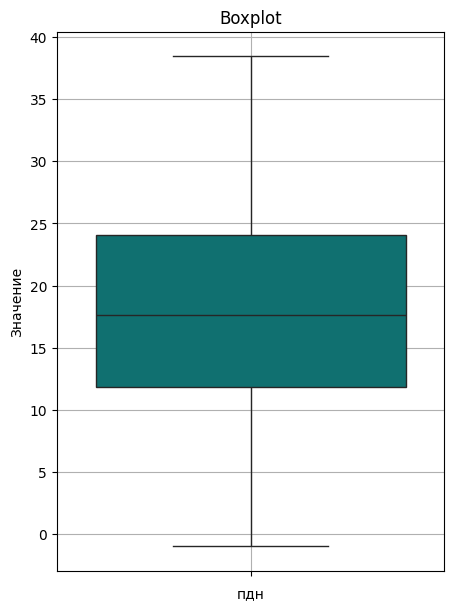

In [39]:
# Boxplor 'пдн' после исправления
fig, ax = plt.subplots(figsize=(5, 7))

sns.boxplot(X_train['пдн'],
            color='teal',
            ax=ax,
            flierprops={
            'marker': 'o',
            'markerfacecolor': 'red',
            'markeredgecolor': 'black',
            'markersize': 4,
            'alpha': 0.7
            })

ax.grid(True)
ax.set_title('Boxplot')
ax.set_xlabel('пдн')
ax.set_ylabel('Значение')

In [40]:
# Ограничим значения 'дата_первого_займа' 1-ым перцентилем
percentil_01_date = X_train['дата_первого_займа'].quantile(0.01)
X_train['дата_первого_займа'] = X_train['дата_первого_займа'].apply(lambda x: x if x >= percentil_01_date else percentil_01_date)
X_valid['дата_первого_займа'] = X_valid['дата_первого_займа'].apply(lambda x: x if x >= percentil_01_date else percentil_01_date)

In [41]:
# Ограничим значения 'сумма_выплат_по_просрочкам' 1-ым перцентилем и 99-ым перцентилем
percentil_01_sum = X_train['сумма_выплат_по_просрочкам'].quantile(0.01)
percentil_99_sum = X_train['сумма_выплат_по_просрочкам'].quantile(0.99)

X_train['сумма_выплат_по_просрочкам'] = X_train['сумма_выплат_по_просрочкам'].apply(lambda x: percentil_01_sum if x <= percentil_01_sum else percentil_99_sum if x >= percentil_99_sum else x)
X_valid['сумма_выплат_по_просрочкам'] = X_valid['сумма_выплат_по_просрочкам'].apply(lambda x: percentil_01_sum if x <= percentil_01_sum else percentil_99_sum if x >= percentil_99_sum else x)

In [42]:
# Ограничим значения 'кол-во_текущих_просроченных_счетов', 'кол-во_списаний_за_год', 'сумма_задолженности' единицей
list_limit_one = ['кол-во_текущих_просроченных_счетов', 'кол-во_списаний_за_год', 'сумма_задолженности']

percentil_99_one = {}
for col in list_limit_one:
    percentil_99_one[col] = X_train[col].quantile(0.99)
    X_train[col] = X_train[col].apply(lambda x: x if x <= percentil_99_one[col] else 1)
    X_valid[col] = X_valid[col].apply(lambda x: x if x <= percentil_99_one[col] else 1)

In [43]:
# Проверяем порядок колонок
assert list(X_valid.columns) == list(X_train.columns)

## Выбор оптимальной ML модели
Для этапа выбора оптимальной модели, чтобы ускорить процесс, возьмем стратифицированную выборку из тренировочных данных

In [44]:
# Стратифицированная выборка - 200к строк(примерно 20%)
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=200000, stratify=y_train, random_state=42)

Разделим для данного этапа их на тестовую и тренировочную выборки

In [45]:
X_train_sample, X_valid_sample, y_train_sample, y_valid_sample = train_test_split(X_sample, y_sample, test_size=0.2,
                                                                                  stratify=y_sample, random_state=42)

del X_sample, y_sample, _

### Сравнивать будем следующие модели: LogisticRegression, RandomForestClassifier, XGBClassifier

### LogisticRegression

In [46]:
# Стандартизируем данные
scaler = StandardScaler()
X_train_sample_scaler = scaler.fit_transform(X_train_sample)
X_valid_sample_scaler = scaler.transform(X_valid_sample)

# Модель логистической регрессии с начальными параметрами
logistic_model = LogisticRegression(
    max_iter=3000,
    random_state=42)

# Гиперпараметры
param_logistic = {'penalty': ['l2'],
                  'C': [0.01, 0.1, 1, 10],
                  'class_weight': [
                      {1: 3, 0: 1},
                      {1: 5, 0: 1},
                      'balanced']
}
# Настройка подбора гиперпараметров с кросс-валидацией
grid_search_cv_logistic = GridSearchCV(logistic_model, param_logistic, cv=5, scoring='roc_auc', n_jobs=8)

In [47]:
# Обучаем LogisticRegression
grid_search_cv_logistic.fit(X_train_sample_scaler, y_train_sample)

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.01, 0.1, ...], 'class_weight': [{0: 1, 1: 3}, {0: 1, 1: 5}, ...], 'penalty': ['l2']}"
,scoring,'roc_auc'
,n_jobs,8
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [48]:
# Лучшая модель
best_model_logistic = grid_search_cv_logistic.best_estimator_

In [49]:
# Предсказываем вероятность принадлежности классу 1 (дефолт)
y_pred_proba_logistic_valid = best_model_logistic.predict_proba(X_valid_sample_scaler)[:, 1]
y_pred_proba_logistic_train = best_model_logistic.predict_proba(X_train_sample_scaler)[:, 1]

# Рассчитываем AUC
fpr_valid, tpr_valid, tresholds_valid = roc_curve(y_valid_sample, y_pred_proba_logistic_valid)
fpr_train, tpr_train, tresholds_train = roc_curve(y_train_sample, y_pred_proba_logistic_train)

roc_auc_logistic_train = round(auc(fpr_train, tpr_train), 4)
roc_auc_logistic_valid = round(auc(fpr_valid, tpr_valid), 4)

print(f'roc_auc для логистической регрессии на тренировочных данных: {roc_auc_logistic_train}' )
print(f'roc_auc для логистической регрессии на валидационных данных: {roc_auc_logistic_valid}' )

roc_auc для логистической регрессии на тренировочных данных: 0.8675
roc_auc для логистической регрессии на валидационных данных: 0.8643


In [50]:
# Очищаем память
del grid_search_cv_logistic, X_valid_sample_scaler, X_train_sample_scaler
gc.collect()

205

### RandomForestClassifier

In [52]:
# Базовая модель
model_randomforest = RandomForestClassifier(
    class_weight='balanced_subsample',
    random_state=42)

# Гиперпараметры
param_randomforest = {'n_estimators': [300, 400],
                      'max_depth': [10, 15],
                      'min_samples_leaf': [10, 20]}

# Настройка подбора гиперпараметров с кросс-валидацией
grid_search_cv_randomforest = GridSearchCV(model_randomforest, param_randomforest, cv=5, scoring='roc_auc', n_jobs=8)

In [53]:
# Обучаем модель
grid_search_cv_randomforest.fit(X_train_sample, y_train_sample)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 15], 'min_samples_leaf': [10, 20], 'n_estimators': [300, 400]}"
,scoring,'roc_auc'
,n_jobs,8
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,400


In [54]:
# Лучшая модель
best_model_randomforest = grid_search_cv_randomforest.best_estimator_

In [55]:
# Предсказываем вероятность принадлежности классу 1 (дефолт)
y_pred_proba_randomforest_valid = best_model_randomforest.predict_proba(X_valid_sample)[:, 1]
y_pred_proba_randomforest_train = best_model_randomforest.predict_proba(X_train_sample)[:, 1]

# Рассчитываем AUC
fpr_valid, tpr_valid, tresholds_valid = roc_curve(y_valid_sample, y_pred_proba_randomforest_valid)
fpr_train, tpr_train, tresholds_train = roc_curve(y_train_sample, y_pred_proba_randomforest_train)

roc_auc_randomforest_train = round(auc(fpr_train, tpr_train), 4)
roc_auc_randomforest_valid = round(auc(fpr_valid, tpr_valid), 4)

print(f'roc_auc для RandomForest на тренировочных данных: {roc_auc_randomforest_train}' )
print(f'roc_auc для RandomForest на валидационных данных: {roc_auc_randomforest_valid}' )

roc_auc для RandomForest на тренировочных данных: 0.9418
roc_auc для RandomForest на валидационных данных: 0.8716


### XGBoost

In [50]:
# Настройки модели
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    max_bin=256,
    scale_pos_weight=4,
    n_jobs=1,
    random_state=42
)

# Гиперпараметры
param_xgb = {
    "max_depth": randint(3, 8),
    "min_child_weight": randint(1, 15),
    "gamma": uniform(0.0, 2.0),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "reg_alpha": uniform(0.0, 2.0),
    "reg_lambda": uniform(1.0, 14.0),
    "learning_rate": uniform(0.02, 0.06),
    "n_estimators": randint(800, 3000),
}

# Настройка случайного подбора гиперпараметров с кросс-валидацией
randomized_search_cv_xgb = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_xgb,
    n_iter=30,
    cv=3,
    scoring='roc_auc',
    n_jobs=1
)

In [ ]:
# Обучаем модель
randomized_search_cv_xgb.fit(X_train_sample, y_train_sample)

In [48]:
randomized_search_cv_xgb.best_params_

{'colsample_bytree': np.float64(0.7529498521518595),
 'gamma': np.float64(0.7698419755694377),
 'learning_rate': np.float64(0.0745557600713481),
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 800,
 'reg_alpha': np.float64(0.06155155035715665),
 'reg_lambda': np.float64(10.70552023115956),
 'subsample': np.float64(0.9106007296136711)}

In [60]:
best_model_xgb = randomized_search_cv_xgb.best_estimator_

In [61]:
# Предсказываем вероятность принадлежности классу 1 (дефолт)
y_pred_proba_xgb_valid = best_model_xgb.predict_proba(X_valid_sample)[:, 1]
y_pred_proba_xgb_train = best_model_xgb.predict_proba(X_train_sample)[:, 1]

# Рассчитываем AUC
fpr_valid, tpr_valid, tresholds_valid = roc_curve(y_valid_sample, y_pred_proba_xgb_valid)
fpr_train, tpr_train, tresholds_train = roc_curve(y_train_sample, y_pred_proba_xgb_train)

roc_auc_xgb_train = round(auc(fpr_train, tpr_train), 4)
roc_auc_xgb_valid = round(auc(fpr_valid, tpr_valid), 4)

print(f'roc_auc для XGBoost на тренировочных данных: {roc_auc_xgb_train}' )
print(f'roc_auc для XGBoost на валидационных данных: {roc_auc_xgb_valid}' )

roc_auc для XGBoost на тренировочных данных: 0.8969
roc_auc для XGBoost на валидационных данных: 0.8772


При выборке 200к строк:  
roc_auc для логистической регрессии на тренировочных данных: 0.8675  
roc_auc для логистической регрессии на валидационных данных: 0.8643  

roc_auc для RandomForest на тренировочных данных: 0.9418  
roc_auc для RandomForest на валидационных данных: 0.8716  
  
roc_auc для XGBoost на тренировочных данных: 0.8969  
roc_auc для XGBoost на валидационных данных: 0.8772  

Учитывая, что логистическая регрессия неплохо себя показала, можно сделать вывод, что зависимость параметров близка к линейной, а данные неплохо подготовлены.  
Хотя все 3 модели показали близкие результаты, наиболее высокий ROC-AUC оказался у XGBoost, поэтому останавливаемся на этой модели. 
  
Лучшие гиперпараметры для XGBoost  
 {'colsample_bytree': 0.4,  
 'learning_rate': 0.03,  
 'max_depth': 5,  
 'min_child_weight': 6,  
 'n_estimators': 541,  
 'reg_alpha': 0.23,  
 'reg_lambda': 4.13,  
 'subsample': 0.86}  
   
'n_estimators' близка к верхней границе поиска. Зададим новый интервал для подбора этого параметра на всех данных для XGBoost

## Финальная модель

In [59]:
# Создаем модель
xgb_model_train = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    n_estimators=5000,
    max_bin=256,
    scale_pos_weight=4,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.86,
    colsample_bytree=0.4,
    reg_alpha=0.23,
    reg_lambda=4.13,
    min_child_weight=6,

    early_stopping_rounds=200,
    save_best=True,
    
    n_jobs=4,
    random_state=42
)

In [ ]:
# Обучим модель с запасом кол-ва деревьев, но с критерием остановки (если нет прироста к roc_auc 200 итераций)
xgb_model_train.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=200
)

[0]	validation_0-auc:0.69526


/home/stipa/SCHOOL_21/SHIFT_stagirovka/SHIFT_ML_2026_COMPETITION/SHIFT_ML_2026_COMPETITION/DELETE_venve/delete_venve/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [22:40:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "save_best" } are not used.

  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-auc:0.87603
[400]	validation_0-auc:0.87860
[600]	validation_0-auc:0.87997
[800]	validation_0-auc:0.88098
[1000]	validation_0-auc:0.88187
[1200]	validation_0-auc:0.88250
[1400]	validation_0-auc:0.88294
[1600]	validation_0-auc:0.88322
[1800]	validation_0-auc:0.88344
[2000]	validation_0-auc:0.88360
[2200]	validation_0-auc:0.88373
[2400]	validation_0-auc:0.88381
[2600]	validation_0-auc:0.88392
[2800]	validation_0-auc:0.88397
[2957]	validation_0-auc:0.88394


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.4
,device,None
,early_stopping_rounds,200
,enable_categorical,False
,eval_metric,'auc'


In [ ]:
# Лучшая итерация
xgb_model_train.best_iteration

2757

In [63]:
# Объединяем данные
X = pd.concat([X_train, X_valid], axis=0)
y = pd.concat([y_train, y_valid])

In [67]:
# Теперь обучим модель на всех данных с небольшим запасом n_estimators (2800)
xgb_model_final = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    n_estimators=2800,
    max_bin=256,
    scale_pos_weight=4,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.86,
    colsample_bytree=0.4,
    reg_alpha=0.23,
    reg_lambda=4.13,
    min_child_weight=6,
    n_jobs=4,
    random_state=42
)

In [68]:
xgb_model_final.fit(X, y)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.4
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [69]:
# Выведем наиболее важные фичи с точки зрения - прирост 'gain'
booster = xgb_model_final.get_booster()

importance_dict = booster.get_score(importance_type="gain")

feat_importances = (
    pd.DataFrame.from_dict(importance_dict, orient="index", columns=["importance"])
    .reset_index()
    .rename(columns={"index": "feature"})
    .sort_values("importance", ascending=False)
)

print(feat_importances.head(10))

                                feature    importance
63               пени_за_дефолт_ЗАКОДИР  10777.906250
23           сумма_выплат_по_просрочкам   1228.740479
2                            допрейтинг    837.436340
1                            срок_займа    825.732849
66                       стаж_ИНДИКАТОР    280.812958
75  подтвержден_ли_доход_Не подтвержден    270.880066
73              владение_жильем_ИПОТЕКА    169.586960
71               владение_жильем_АРЕНДА    161.608078
32     кол-во_открытых_счетов_за_2_года    152.779282
15       нижний_порог_рейтинга_заемщика    146.888947


### Топ-3 наиболее информативные фичи: пени_за_дефолт, сумма_выплат_по_просрочкам, допрейтинг

# Тестирование модели

In [70]:
test_data = pd.read_csv('shift_ml_2026_test.csv')

Подготовим данные, также как X_valid

In [71]:
# Отсекаем столбцы с пропусками >= 50% (24 шт.), т.к. они будут неинформативны при обучении модели
test_data = test_data.drop(cols_drop, axis=1)

# Удаляем неинформативные столбцы
test_data = test_data.drop(drop_columns, axis=1)

# Заменяем значения в столбце "пени_за_дефолт"
test_data['пени_за_дефолт_ЗАКОДИР'] = test_data['пени_за_дефолт'].map(map_peni)
test_data = test_data.drop('пени_за_дефолт', axis=1)

# Заменяем пропуски на (-1) + колонка-индикатор
test_data['кол-во_мес_с_последней_заявки_ИНДИКАТОР'] = test_data['кол-во_мес_с_последней_заявки'].isna().astype(int)
test_data['кол-во_мес_с_последней_заявки'] = test_data['кол-во_мес_с_последней_заявки'].fillna(-1.0)

# Заменяем NaN в сгруппированных столбцах
test_data['ИНДИКАТОР_1'] = test_data[list_col_one[0]].isna().astype(int)
test_data[list_col_one] = test_data[list_col_one].fillna(-1)

test_data['ИНДИКАТОР_2'] = test_data[list_col_one_2[0]].isna().astype(int)
test_data[list_col_one_2] = test_data[list_col_one_2].fillna(-1)

test_data['ИНДИКАТОР_3'] = test_data[list_col_one_3[0]].isna().astype(int)
test_data[list_col_one_3] = test_data[list_col_one_3].fillna(-1)

# Заменяем NaN в колонках 'missing_perc' < 1 на медианно значение
test_data[list_col_median] = test_data[list_col_median].fillna(median_value)

# Заменяем NaN в остальных колонках, кроме "профессия_заемщика" (в ней на "нет_данных")
for col in list_col_others:
    test_data[f'{col}_ИНДИКАТОР'] = test_data[col].isna().astype(int)

test_data[new_list_col_others] = test_data[new_list_col_others].fillna(-1)
test_data['профессия_заемщика'] = test_data['профессия_заемщика'].fillna('нет_данных')

# Новый столбец - чaстотность профессий
test_data['частотность_профессии_заемщика'] = test_data['профессия_заемщика'].map(value_counts_prof).fillna(value_counts_prof.loc['нет_данных'])

# Новый столбец - редкость профессии
test_data['редкая_профессия_заемщика'] = ((test_data['частотность_профессии_заемщика'] / len(X_train)) < 0.001).astype(int)

# Новый столбец - топ 20 профессий (кроме строк где нет данных)
test_data['ТОП20_профессий_заемщика'] = test_data['профессия_заемщика'].isin(top_20_prof).astype(int)
test_data = test_data.drop('профессия_заемщика', axis=1)

# Заменяем значеня в "допрейтинг" на упорядлоченный числовой рейтинг
test_data['допрейтинг'] = test_data['допрейтинг'].map(dict_value).fillna(-1)
test_data = test_data.drop('рейтинг', axis=1)

# Заменяем значения в колонке "стаж"
test_data['стаж'] = test_data['стаж'].apply(lambda x: -1 if type(x)==int else 0 if x.split()[0]=='<' else
                                            10 if x.split()[0]=='10+' else int(x.split()[0]))

# Объединяем малочисленные значения
test_data['владение_жильем'] = test_data['владение_жильем'].apply(lambda x: 'ДРУГОЕ' if x in list_ownership else x)

# Заменяем малочисленные значения
test_data['цель_займа'] = test_data['цель_займа'].apply(lambda x: 'лечение' if x in ['переезд', 'возобновляемая_энергия'] else 
                                                    'крупная_покупка' if x == 'отпуск' else 
                                                    'консолидация_долга' if x == 'дом' else 'автомобиль' if x in ['свадьба', 'образование'] else x
                                                    if x in list_purpose else 'другое')

# One Hot Encoding
X_test_dummies = pd.get_dummies(test_data[one_hot_list], prefix=one_hot_list, dtype=int)
test_data = pd.concat([test_data, X_test_dummies], axis=1)
test_data = test_data.drop(one_hot_list, axis=1)
del X_test_dummies

# Остальная обработка
test_data['тип_займа'] = test_data['тип_займа'].map(replace_type)
test_data['пос_стоп_фактор'] = test_data['пос_стоп_фактор'].map(replace_factor)
test_data['юридический_статус'] = test_data['юридический_статус'].map(replace_status)
test_data['дата_первого_займа'] = test_data['дата_первого_займа'].apply(lambda x: int(x.split('-')[1]))
test_data['первоначальный_статус_займа'] = test_data['первоначальный_статус_займа'].map(replace_loan_status)
test_data['тип_предоставления_кредита'] = test_data['тип_предоставления_кредита'].map(replace_type_cash)
test_data['срок_займа'] = test_data['срок_займа'].map(replace_loan_term)

# 'регион' - Target Encoding  
test_data['доля_дефолтов_по_регионам'] = test_data['регион'].map(temp_data_region_unique['доля_дефолтов']).fillna(0)
test_data = test_data.drop('регион', axis=1)

# Удаляем коррелирующие фичи
test_data = test_data.drop(list_corr_drop, axis=1)

# Обрабатываем выбросы
for col, val in percentil_99.items():
    test_data[col] = test_data[col].apply(lambda x: x if x <= val else val)

test_data['дата_первого_займа'] = test_data['дата_первого_займа'].apply(lambda x: x if x >= percentil_01_date else percentil_01_date)
test_data['сумма_выплат_по_просрочкам'] = test_data['сумма_выплат_по_просрочкам'].\
    apply(lambda x: percentil_01_sum if x <= percentil_01_sum else percentil_99_sum if x >= percentil_99_sum else x)

for col, val in percentil_99_one.items():
    test_data[col] = test_data[col].apply(lambda x: x if x <= val else 1)

# Добавляем колонку 'id' в датафрейм, в котором будут результаты предсказания
answer = pd.DataFrame()
answer['id'] = test_data['id']

# Удалим неинформативный столбец "id"
test_data = test_data.drop('id', axis=1)


In [72]:
# Проверяем, что колонки выставлены в нужном порядке
assert list(test_data.columns) == list(X_train.columns)

## Предсказание вероятности принадлежания к классу 1

In [73]:
# Делаем предсказания
test_predict = xgb_model_final.predict_proba(test_data)[:, 1]

# Формируем сабмит
answer['proba'] = test_predict
answer.to_csv('submission.csv', index=False)